In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
#1 Import relavant files
import sys
import os 
sys.path.append(os.path.abspath('../src'))
import numpy as np
import pandas as pd

from data_processor import DataProcessor
from data_processor import CycleProcessor
from feature_engineering import FeatureEngineering, PhysicsBasedFeatures
from model.coarse_feature_selection.cfs import random_forest_regressor
from model.fine_feature_selection.ffs import fine_feature_selection 
from model.lstm_model.enhanced_lstm import lstm_model

In [3]:
# Define file path 
file_path = '../data/raw/data_factory_1.xlsx'  
dp = DataProcessor(file_path)
dp.change_pivot('timestamp', 'param_name', 'value')
# drop missing values of input features
dp.drop_NA_with_feature(features=['FeedFlow','FeedTemperature'])
# Standardize the feature names
dp.rename_column_to_timestamp('timestamp')
if 'Permeate Pressure' in dp.list_columns():
    dp.rename_column_to_permeatepressure('Permeate Pressure')
dp.list_columns()



['timestamp', 'ConcentrateFlow', 'ConcentratePressure', 'DifferentialPressure', 'FeedConductivity', 'FeedFlow', 'FeedPressure', 'FeedTemperature', 'Permeate Pressure', 'PermeateConductivity', 'PermeateFlow', 'Recovery']
['timestamp', 'ConcentrateFlow', 'ConcentratePressure', 'DifferentialPressure', 'FeedConductivity', 'FeedFlow', 'FeedPressure', 'FeedTemperature', 'PermeatePressure', 'PermeateConductivity', 'PermeateFlow', 'Recovery']


['timestamp',
 'ConcentrateFlow',
 'ConcentratePressure',
 'DifferentialPressure',
 'FeedConductivity',
 'FeedFlow',
 'FeedPressure',
 'FeedTemperature',
 'PermeatePressure',
 'PermeateConductivity',
 'PermeateFlow',
 'Recovery']

In [4]:
# # 2 Cycle Processing 
# cp = CycleProcessor(column_name='FeedFlow', df=dp.df, threshold=10)
# cp.identify_cycles()a
# cp.export_files('../data/processed/cycle_data_factory_1.csv')
# cp.assign_cycle_features()
# cp.export_files('../data/processed/cycle_data_factory_1_with_cycle_features.csv')




In [5]:
dp.list_columns()

['timestamp', 'ConcentrateFlow', 'ConcentratePressure', 'DifferentialPressure', 'FeedConductivity', 'FeedFlow', 'FeedPressure', 'FeedTemperature', 'PermeatePressure', 'PermeateConductivity', 'PermeateFlow', 'Recovery']


['timestamp',
 'ConcentrateFlow',
 'ConcentratePressure',
 'DifferentialPressure',
 'FeedConductivity',
 'FeedFlow',
 'FeedPressure',
 'FeedTemperature',
 'PermeatePressure',
 'PermeateConductivity',
 'PermeateFlow',
 'Recovery']

In [6]:
# 3 Feature Engineering
fe = FeatureEngineering(dp)

drop_features_cross = ['Recovery', 'PermeateFlow', 'PermeateConductivity', 'PermeatePressure', 'cycle_id', 'cycle_time', 'DifferentialPressure']
drop_features_lag = ['cycle_id', 'cycle_time']

fe.generate_cross_features(drop_features=drop_features_cross)
fe.lag_engineer(drop_features=drop_features_lag, mode='global')



In [7]:
pe = PhysicsBasedFeatures(fe)
fe.df['Physics_DP_Predicted'] = pe.differential_pressure(
    flow_col='FeedFlow', 
    temp_col='FeedTemperature', 
    calibration_col='DifferentialPressure'
)

Auto-calibrated k: 0.0094


In [8]:
fe.df['Physics_Permeate_Press'] = pe.estimate_permeate_pressure(
    feed_press_col='FeedPressure',
    feed_cond_col='FeedConductivity',
    physics_dp_col='Physics_DP_Predicted',        # Use the column we just made
    permeate_flow_col='PermeateFlow',   # Needed to calculate Flux
    actual_perm_press_col='PermeatePressure', # Used to learn "A"
    membrane_area_m2=37.0 * 6           # e.g., if you have 6 elements in a vessel
)

Auto-calibrated Permeability (A): 0.0074 (m/h/bar)


In [9]:
features = fe.df.columns.tolist()
features

['timestamp',
 'ConcentrateFlow',
 'ConcentratePressure',
 'DifferentialPressure',
 'FeedConductivity',
 'FeedFlow',
 'FeedPressure',
 'FeedTemperature',
 'PermeatePressure',
 'PermeateConductivity',
 'PermeateFlow',
 'Recovery',
 'ConcentrateFlow_x_ConcentratePressure',
 'ConcentrateFlow_x_FeedConductivity',
 'ConcentrateFlow_x_FeedFlow',
 'ConcentrateFlow_x_FeedPressure',
 'ConcentrateFlow_x_FeedTemperature',
 'ConcentratePressure_x_FeedConductivity',
 'ConcentratePressure_x_FeedFlow',
 'ConcentratePressure_x_FeedPressure',
 'ConcentratePressure_x_FeedTemperature',
 'FeedConductivity_x_FeedFlow',
 'FeedConductivity_x_FeedPressure',
 'FeedConductivity_x_FeedTemperature',
 'FeedFlow_x_FeedPressure',
 'FeedFlow_x_FeedTemperature',
 'FeedPressure_x_FeedTemperature',
 'ConcentrateFlow_lag_1',
 'ConcentrateFlow_lag_2',
 'ConcentrateFlow_lag_3',
 'ConcentrateFlow_lag_6',
 'ConcentrateFlow_lag_12',
 'ConcentratePressure_lag_1',
 'ConcentratePressure_lag_2',
 'ConcentratePressure_lag_3',
 'Co

In [10]:
len(features)

84

In [11]:
fe.df.shape

(16171, 84)

In [12]:
fe.df.to_csv('../data/processed/features_diffPressure.csv', index=False)

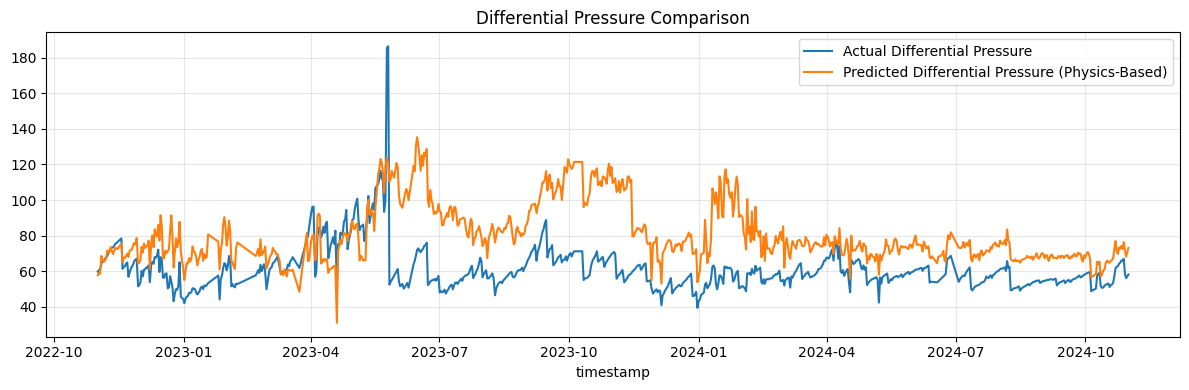

In [13]:
import matplotlib.pyplot as plt
k = 20               # take one point every 50 rows
df_plot = fe.df.iloc[::k].copy()


plt.figure(figsize=(12,4))
plt.plot(df_plot['timestamp'], df_plot['DifferentialPressure'], label='Actual Differential Pressure')
plt.plot(df_plot['timestamp'],   df_plot['Physics_DP_Predicted'], label='Predicted Differential Pressure (Physics-Based)')
plt.title('Differential Pressure Comparison')
plt.xlabel('timestamp')
# plt.ylabel('Differential Pressure')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# # visualize inputs over timestamp
# # make sure timestamp is datetime
# if 'timestamp' in df_plot.columns:
#     df_plot['timestamp'] = pd.to_datetime(df_plot['timestamp'])

#     for col in df_plot.columns:
#         if col in ['timestamp']:  # skip timestamp as a y-value
#             continue
        
#         plt.figure(figsize=(12, 4))
#         plt.plot(df_plot['timestamp'], df_plot[col])
#         plt.title(col)
#         plt.xlabel('timestamp')
#         plt.ylabel(col)
#         plt.grid(True, alpha=0.3)
#         plt.tight_layout()


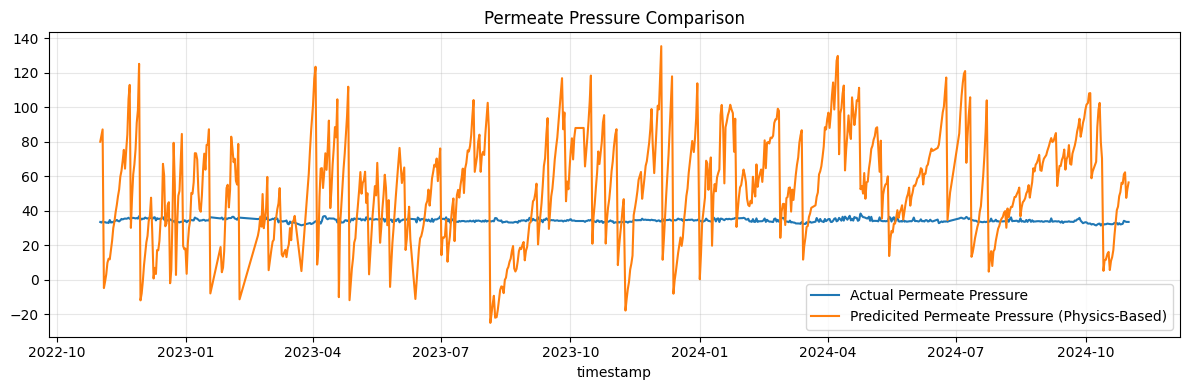

In [14]:
plt.figure(figsize=(12,4))
plt.plot(df_plot['timestamp'], df_plot['PermeatePressure'], label='Actual Permeate Pressure')
plt.plot(df_plot['timestamp'], df_plot['Physics_Permeate_Press'], label='Predicited Permeate Pressure (Physics-Based)')
plt.title('Permeate Pressure Comparison')
plt.xlabel('timestamp')
# plt.ylabel('Permeate Pressure')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [15]:
target = ['DifferentialPressure', 'Physics_DP_Predicted', 'Physics_Permeate_Press']

In [16]:
fs = [f for f in features if f != ''and 'timestamp' not in f and 'ConcentratePressure' not in f  and 'PermeatePressure' not in f and 'PermeateConductivity' not in f and f not in target ]
fs

['ConcentrateFlow',
 'FeedConductivity',
 'FeedFlow',
 'FeedPressure',
 'FeedTemperature',
 'PermeateFlow',
 'Recovery',
 'ConcentrateFlow_x_FeedConductivity',
 'ConcentrateFlow_x_FeedFlow',
 'ConcentrateFlow_x_FeedPressure',
 'ConcentrateFlow_x_FeedTemperature',
 'FeedConductivity_x_FeedFlow',
 'FeedConductivity_x_FeedPressure',
 'FeedConductivity_x_FeedTemperature',
 'FeedFlow_x_FeedPressure',
 'FeedFlow_x_FeedTemperature',
 'FeedPressure_x_FeedTemperature',
 'ConcentrateFlow_lag_1',
 'ConcentrateFlow_lag_2',
 'ConcentrateFlow_lag_3',
 'ConcentrateFlow_lag_6',
 'ConcentrateFlow_lag_12',
 'DifferentialPressure_lag_1',
 'DifferentialPressure_lag_2',
 'DifferentialPressure_lag_3',
 'DifferentialPressure_lag_6',
 'DifferentialPressure_lag_12',
 'FeedConductivity_lag_1',
 'FeedConductivity_lag_2',
 'FeedConductivity_lag_3',
 'FeedConductivity_lag_6',
 'FeedConductivity_lag_12',
 'FeedFlow_lag_1',
 'FeedFlow_lag_2',
 'FeedFlow_lag_3',
 'FeedFlow_lag_6',
 'FeedFlow_lag_12',
 'FeedPressure_l

In [17]:
len(fs)

57

训练 RandomForest...
训练 simple RandomForest...


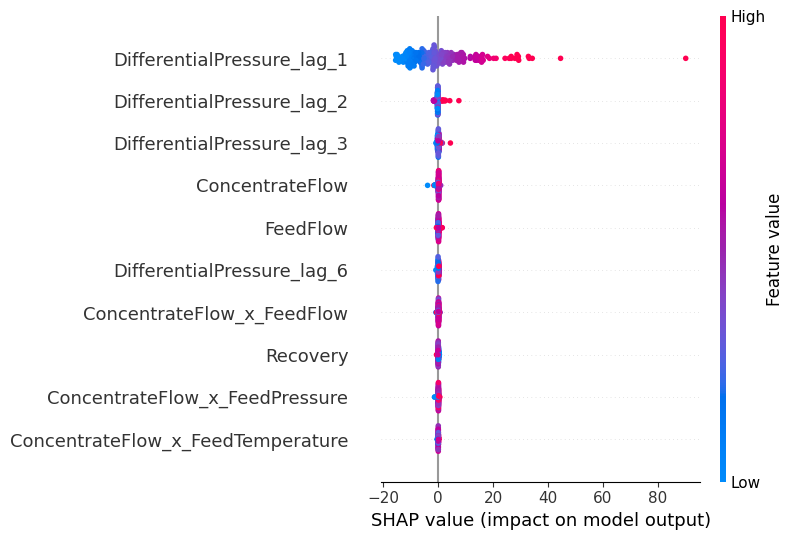

In [18]:
# 4 Coarse Feature Selection 
top_k_features = random_forest_regressor(fe,'DifferentialPressure', fs, plant_name='FACT1')

In [19]:
# 1. Define your column names
actual_col = 'DifferentialPressure'      # The sensor reading
physics_col = 'Physics_DP_Predicted'     # The column you generated earlier
target_col_name = 'DP_Residual'          # The new target for LSTM

# 2. Calculate the residuals
fe.df[target_col_name] = fe.df[actual_col] - fe.df[physics_col]


In [20]:
fe.df.head()

,timestamp,ConcentrateFlow,ConcentratePressure,DifferentialPressure,FeedConductivity,FeedFlow,FeedPressure,FeedTemperature,PermeatePressure,PermeateConductivity,...,PermeateFlow_lag_6,PermeateFlow_lag_12,Recovery_lag_1,Recovery_lag_2,Recovery_lag_3,Recovery_lag_6,Recovery_lag_12,Physics_DP_Predicted,Physics_Permeate_Press,DP_Residual
0,2022-11-01 00:00:00,119.058464,254.427083,59.811424,238.884183,387.863646,273.325000,83.620000,33.441771,2.684261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.692732,79.985135,2.118692
1,2022-11-01 01:00:00,119.284861,254.408333,59.793070,239.050850,388.577708,273.159583,83.740000,33.405078,2.690898,...,NaN,NaN,69.427135,NaN,NaN,NaN,NaN,57.706975,79.474735,2.086095
2,2022-11-01 02:00:00,118.848508,254.044583,59.789896,239.117517,386.958541,272.952917,83.768333,33.316614,2.695333,...,NaN,NaN,69.401548,69.427135,NaN,NaN,NaN,57.259841,80.094198,2.530055
3,2022-11-01 03:00:00,118.631324,253.052917,59.742965,239.234183,388.434167,271.841667,84.445000,33.036159,2.644088,...,NaN,NaN,69.404638,69.401548,69.427135,NaN,NaN,56.703161,78.292155,3.039804
4,2022-11-01 04:00:00,118.826094,254.352500,59.799096,239.217517,387.695000,273.296667,84.073333,33.177526,2.674923,...,NaN,NaN,69.566374,69.404638,69.401548,NaN,NaN,57.026261,80.097823,2.772835


In [21]:
# fe.df.to_csv('../data/processed/features_diffPressure_with_residual.csv', index=False)

[autoreload of model.lstm_model.enhanced_lstm failed: Traceback (most recent call last):
  File "c:\Users\Boom\OneDrive - International Campus, Zhejiang University\Year 4\ECE498GRP\Code\RO\RO\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Boom\OneDrive - International Campus, Zhejiang University\Year 4\ECE498GRP\Code\RO\RO\.venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 545, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
UnicodeDecodeError: 'gbk' codec can't decode byte 0xa8 in position 629: illegal multibyte sequence
]


Scaler已保存到: ../data/model_data/scaler_x_DiffPress.pkl
Scaler已保存到: ../data/model_data/scaler_y_DiffPress.pkl


Epoch 1/100: 100%|██████████| 188/188 [00:05<00:00, 33.36it/s]


Epoch [1/100]  Train Loss: 0.2996  Test Loss: 0.0315


Epoch 2/100: 100%|██████████| 188/188 [00:04<00:00, 45.29it/s]


Epoch [2/100]  Train Loss: 0.2104  Test Loss: 0.0168


Epoch 3/100: 100%|██████████| 188/188 [00:03<00:00, 53.78it/s]


Epoch [3/100]  Train Loss: 0.1033  Test Loss: 0.0165


Epoch 4/100: 100%|██████████| 188/188 [00:03<00:00, 55.75it/s]


Epoch [4/100]  Train Loss: 0.0854  Test Loss: 0.0113


Epoch 5/100: 100%|██████████| 188/188 [00:03<00:00, 54.19it/s]


Epoch [5/100]  Train Loss: 0.0718  Test Loss: 0.0125


Epoch 6/100: 100%|██████████| 188/188 [00:03<00:00, 53.91it/s]


Epoch [6/100]  Train Loss: 0.0658  Test Loss: 0.0105


Epoch 7/100: 100%|██████████| 188/188 [00:03<00:00, 57.86it/s]


Epoch [7/100]  Train Loss: 0.0598  Test Loss: 0.0158


Epoch 8/100: 100%|██████████| 188/188 [00:03<00:00, 57.60it/s]


Epoch [8/100]  Train Loss: 0.0601  Test Loss: 0.0149


Epoch 9/100: 100%|██████████| 188/188 [00:03<00:00, 58.80it/s]


Epoch [9/100]  Train Loss: 0.0558  Test Loss: 0.0082


Epoch 10/100: 100%|██████████| 188/188 [00:03<00:00, 55.50it/s]


Epoch [10/100]  Train Loss: 0.0464  Test Loss: 0.0101


Epoch 11/100: 100%|██████████| 188/188 [00:05<00:00, 36.78it/s]


Epoch [11/100]  Train Loss: 0.0486  Test Loss: 0.0075


Epoch 12/100: 100%|██████████| 188/188 [00:04<00:00, 39.79it/s]


Epoch [12/100]  Train Loss: 0.0429  Test Loss: 0.0053


Epoch 13/100: 100%|██████████| 188/188 [00:03<00:00, 50.70it/s]


Epoch [13/100]  Train Loss: 0.0415  Test Loss: 0.0099
Early stopping at epoch 13
Inverse transforming predictions to original scale...
R2 Score: 0.5621, MAE: 1.5778


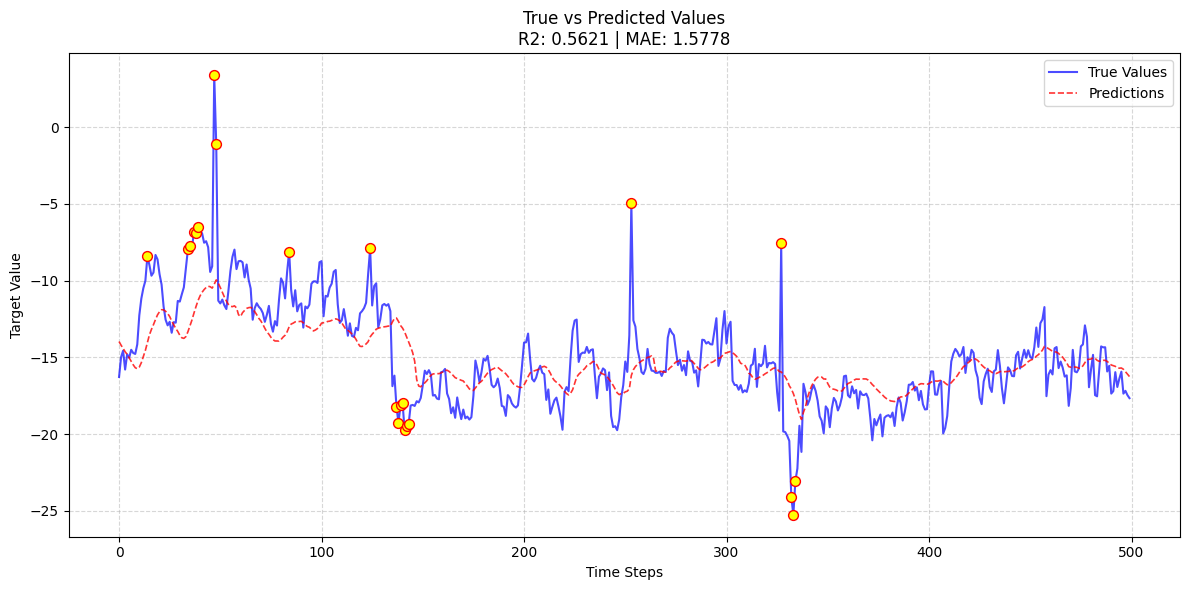

In [23]:
lstm_model(fe, top_k_features,['DP_Residual'], feature_name='DiffPress')

In [ ]:
# 4 Coarse Feature Selection 
top_k_features = random_forest_regressor(fe,'DifferentialPressure', fs, plant_name='FACT1')